In [ ]:
https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import datetime
import pandas as pd
import numpy as np
import time
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

# import convoys
# import convoys.plotting
# import convoys.regression
# import convoys.single
# import convoys.utils

pd.set_option('display.max_columns', 273)
pd.set_option('display.max_rows', 273)

eu = pd.read_excel('COVID-19-geographic-disbtribution-worldwide-2020-11-30.xlsx')

eu = eu.drop(['geoId'], axis=1)

eu.rename(columns={'dateRep': 'DATE'}, inplace=True)
eu.rename(columns={'countriesAndTerritories': 'COUNTRY'}, inplace=True)
eu.rename(columns={'cases': 'CASES'}, inplace=True)
eu.rename(columns={'deaths': 'DEATHS'}, inplace=True)
eu.rename(columns={'popData2019': 'POPULATION'}, inplace=True)

## COLUMN of the Cumulative Cases

def custcum(x):
    x = x.sort_values(by='DATE')
    total = 0
    for i, v in x.iterrows():
        total += v.CASES
        country = v.COUNTRY
        x.loc[i, 'CUM_CASES'] = total
        if country != v.COUNTRY:
            total = 0
    return x

eu = eu.groupby('COUNTRY').apply(custcum)
eu = eu.drop(['COUNTRY'], axis=1)
eu = eu.reset_index()
eu = eu.drop(['level_1'], axis=1)

## COLUMN of the Cumulative Deaths

def custcum(x):
    x = x.sort_values(by='DATE')
    total = 0
    for i, v in x.iterrows():
        total += v.DEATHS
        country = v.COUNTRY
        x.loc[i, 'CUM_DEATHS'] = total
        if country != v.COUNTRY:
            total = 0
    return x

eu = eu.groupby('COUNTRY').apply(custcum)
eu = eu.drop(['COUNTRY'], axis=1)
eu = eu.reset_index()
eu = eu.drop(['level_1'], axis=1)

eu['INFECTED_CUM_FRXN'] = (eu.CUM_CASES / eu.POPULATION)

### getting the at least 5 infections date per country ######
country_list = eu.groupby('COUNTRY').min().index.values
first_infxn_list = []
for country in eu.groupby('COUNTRY').min().index.values:
    first_infxn_list.append(eu[(eu.COUNTRY == country) & (eu.CASES > 5)].DATE.min())

dataset = pd.DataFrame({'AT_LEAST_5_DAILY_CASES_DATE': first_infxn_list, 'COUNTRY': country_list})

eu = pd.merge(eu, dataset, right_on='COUNTRY', left_on='COUNTRY', how='inner')
eu.rename(columns={'DATE_y': 'FIRST_INFEXN_DATE'}, inplace=True)
eu.rename(columns={'DATE_x': 'DATE'}, inplace=True)

eu['DAYS_SINCE_5_INFXNS'] = (eu.DATE - eu.AT_LEAST_5_DAILY_CASES_DATE).dt.days


### getting the date per country where > 1 in 1e6 ? are infected ######
country_list = eu.groupby('COUNTRY').min().index.values
first_infxn_list = []
for country in eu.groupby('COUNTRY').min().index.values:
    first_infxn_list.append(eu[(eu.COUNTRY == country) & (eu.INFECTED_CUM_FRXN > 1e-6)].DATE.min())

dataset = pd.DataFrame({'AT_LEAST_1_in_1e6_infected': first_infxn_list, 'COUNTRY': country_list})

eu = pd.merge(eu, dataset, right_on='COUNTRY', left_on='COUNTRY', how='inner')
eu.rename(columns={'DATE_y': 'START_DATE'}, inplace=True)
eu.rename(columns={'DATE_x': 'DATE'}, inplace=True)

eu['DAYS_SINCE_INFXN_START'] = (eu.DATE - eu.AT_LEAST_1_in_1e6_infected).dt.days



In [2]:
eu.head()

,COUNTRY,DATE,day,month,year,CASES,DEATHS,countryterritoryCode,POPULATION,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,CUM_CASES,CUM_DEATHS,INFECTED_CUM_FRXN,AT_LEAST_5_DAILY_CASES_DATE,DAYS_SINCE_5_INFXNS,AT_LEAST_1_in_1e6_infected,DAYS_SINCE_INFXN_START
0,Afghanistan,2019-12-31,31,12,2019,0,0,AFG,38041757.0,Asia,NaN,0.0,0.0,0.0,2020-03-16,-76.0,2020-03-24,-84.0
1,Afghanistan,2020-01-01,1,1,2020,0,0,AFG,38041757.0,Asia,NaN,0.0,0.0,0.0,2020-03-16,-75.0,2020-03-24,-83.0
2,Afghanistan,2020-01-02,2,1,2020,0,0,AFG,38041757.0,Asia,NaN,0.0,0.0,0.0,2020-03-16,-74.0,2020-03-24,-82.0
3,Afghanistan,2020-01-03,3,1,2020,0,0,AFG,38041757.0,Asia,NaN,0.0,0.0,0.0,2020-03-16,-73.0,2020-03-24,-81.0
4,Afghanistan,2020-01-04,4,1,2020,0,0,AFG,38041757.0,Asia,NaN,0.0,0.0,0.0,2020-03-16,-72.0,2020-03-24,-80.0


In [3]:
print (len(eu.groupby('COUNTRY').count().index.values), ' Count of Countries')
print('')

country1 = 'United_States_of_America'#'China'
country2 = 'Italy'
country3 = 'South_Korea'
country4 = 'Japan'
country5 = 'Ireland'
country6 = 'Spain'
country7 = 'France'
country8 = 'Iran'
country9 = 'United_Kingdom'
country10 = 'China' #'United States of America'

frxn1  = np.divide(np.cumsum(eu[eu.COUNTRY == country1].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country1].POPULATION.values[0])
frxn2  = np.divide(np.cumsum(eu[eu.COUNTRY == country2].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country2].POPULATION.values[0])
frxn3  = np.divide(np.cumsum(eu[eu.COUNTRY == country3].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country3].POPULATION.values[0])
frxn4  = np.divide(np.cumsum(eu[eu.COUNTRY == country4].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country4].POPULATION.values[0])
frxn5  = np.divide(np.cumsum(eu[eu.COUNTRY == country5].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country5].POPULATION.values[0])
frxn6  = np.divide(np.cumsum(eu[eu.COUNTRY == country6].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country6].POPULATION.values[0])
frxn7  = np.divide(np.cumsum(eu[eu.COUNTRY == country7].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country7].POPULATION.values[0])
frxn8  = np.divide(np.cumsum(eu[eu.COUNTRY == country8].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country8].POPULATION.values[0])
frxn9  = np.divide(np.cumsum(eu[eu.COUNTRY == country9].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country9].POPULATION.values[0])
frxn10 = np.divide(np.cumsum(eu[eu.COUNTRY == country10].sort_values(by = 'DATE').CASES).values, eu[eu.COUNTRY == country10].POPULATION.values[0])

abs1  = np.cumsum(eu[eu.COUNTRY == country1].sort_values(by = 'DATE').CASES).values
abs2  = np.cumsum(eu[eu.COUNTRY == country2].sort_values(by = 'DATE').CASES).values
abs3  = np.cumsum(eu[eu.COUNTRY == country3].sort_values(by = 'DATE').CASES).values
abs4  = np.cumsum(eu[eu.COUNTRY == country4].sort_values(by = 'DATE').CASES).values
abs5  = np.cumsum(eu[eu.COUNTRY == country5].sort_values(by = 'DATE').CASES).values
abs6  = np.cumsum(eu[eu.COUNTRY == country6].sort_values(by = 'DATE').CASES).values
abs7  = np.cumsum(eu[eu.COUNTRY == country7].sort_values(by = 'DATE').CASES).values
abs8  = np.cumsum(eu[eu.COUNTRY == country8].sort_values(by = 'DATE').CASES).values
abs9  = np.cumsum(eu[eu.COUNTRY == country9].sort_values(by = 'DATE').CASES).values
abs10 = np.cumsum(eu[eu.COUNTRY == country10].sort_values(by = 'DATE').CASES).values

x1  = eu[eu.COUNTRY == country1].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x2  = eu[eu.COUNTRY == country2].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x3  = eu[eu.COUNTRY == country3].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x4  = eu[eu.COUNTRY == country4].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x5  = eu[eu.COUNTRY == country5].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x6  = eu[eu.COUNTRY == country6].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x7  = eu[eu.COUNTRY == country7].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x8  = eu[eu.COUNTRY == country8].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x9  = eu[eu.COUNTRY == country9].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values
x10 = eu[eu.COUNTRY == country10].sort_values(by = 'DATE').DAYS_SINCE_INFXN_START.values

214  Count of Countries



In [4]:
eu[eu.COUNTRY == 'United_States_of_America']

,COUNTRY,DATE,day,month,year,CASES,DEATHS,countryterritoryCode,POPULATION,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,CUM_CASES,CUM_DEATHS,INFECTED_CUM_FRXN,AT_LEAST_5_DAILY_CASES_DATE,DAYS_SINCE_5_INFXNS,AT_LEAST_1_in_1e6_infected,DAYS_SINCE_INFXN_START
56422,United_States_of_America,2019-12-31,31,12,2019,0,0,USA,329064917.0,America,NaN,0.0,0.0,0.000000,2020-02-22,-53.0,2020-03-07,-67.0
56423,United_States_of_America,2020-01-01,1,1,2020,0,0,USA,329064917.0,America,NaN,0.0,0.0,0.000000,2020-02-22,-52.0,2020-03-07,-66.0
56424,United_States_of_America,2020-01-02,2,1,2020,0,0,USA,329064917.0,America,NaN,0.0,0.0,0.000000,2020-02-22,-51.0,2020-03-07,-65.0
56425,United_States_of_America,2020-01-03,3,1,2020,0,0,USA,329064917.0,America,NaN,0.0,0.0,0.000000,2020-02-22,-50.0,2020-03-07,-64.0
56426,United_States_of_America,2020-01-04,4,1,2020,0,0,USA,329064917.0,America,NaN,0.0,0.0,0.000000,2020-02-22,-49.0,2020-03-07,-63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56753,United_States_of_America,2020-11-26,26,11,2020,186589,2341,USA,329064917.0,America,722.234999,12777754.0,262266.0,0.038830,2020-02-22,278.0,2020-03-07,264.0
56754,United_States_of_America,2020-11-27,27,11,2020,106091,1189,USA,329064917.0,America,707.776454,12883845.0,263455.0,0.039153,2020-02-22,279.0,2020-03-07,265.0
56755,United_States_of_America,2020-11-28,28,11,2020,207913,1404,USA,329064917.0,America,714.796345,13091758.0,264859.0,0.039785,2020-02-22,280.0,2020-03-07,266.0
56756,United_States_of_America,2020-11-29,29,11,2020,154893,1204,USA,329064917.0,America,711.640737,13246651.0,266063.0,0.040255,2020-02-22,281.0,2020-03-07,267.0


In [5]:
"""
SI_IR disease model
Write in the equation here.


States:

Susceptibles: S

Asymptomatic period. Assume case severity is predetermined and each severity may have a unique incubation period.
The asymptomatic population is assumed infectious and unconfirmed.
Asymptomatic states; A_M, A_S, A_C

Symptomatic states; 
Mild_Unconfirmed, Mild_Confirmed, Severe, & Critical. Severe & Critcal are assumed confirmed.

Symptomatics States; M_U, M_C, S_C, C_C

Removed states; Recovered & Died. R, D

States; S, A_M, A_S, A_C, M_U, M_C, S_C, C_C, R, D


Parameters:

T, Testing rate, controls the ratio of Mild Confirmed and Unconfirmed cases.
B, Transmissivity, Beta, controls the chance of infection given contact with an Infectious

G_M, Probability of a case being Mild
G_S, Probability of a case being Severe
G_C, Probability of a case being Critical

K_M, Rate at which a Mild case produces symptoms
K_S, Rate at which a Severe case produces symptoms
K_C, Rate at which a Critical case produces symptoms

R_M, Rate at which a mild case recovers
R_S, Rate at which a Severe case recovers
R_C, Rate at which a Critical case recovers

D_S, Death Rate Severe, Delta Severe, rate at which a Severe case dies
D_C, Death Rate Critical, Delta Critical,rate at which a Critical case dies

Parameters; T, B, G_M ,G_S, G_C, K_M, K_S, K_C, R_M, R_S, R_C, D_S, D_C

"""

import numpy as np
from ODESolver import ForwardEuler
from matplotlib import pyplot as plt

class SI_IR:
    def __init__(self, T, B, G_M, G_S, G_C, K_M, K_S, K_C, R_M, R_S, R_C, D_S, D_C,        # Rates & Probabilities
                 S0, A_M_0, A_S_0, A_C_0, M_U_0, M_C_0, S_C_0, C_C_0, R_0, D_0):          # States
        """
        T, B, G_M ,G_S, G_C, K_M, K_S, K_C, R_M, R_S, R_C, D_S, D_C: parameters in the ODE system
        S0, A_M_0, A_S_0, A_C_0, M_U_0, M_C_0, S_C_0, C_C_0, R_0, D_0: initial values
        """

        if isinstance(T, (float, int)):
            self.T = lambda t: T 
        elif callable(T):
            self.T = T
            
        if isinstance(B, (float, int)):
            self.B = lambda t: B 
        elif callable(B):
            self.B = B

            
            
## Severity Frxns ##### Severity Frxns ##### Severity Frxns ##### Severity Frxns ##### Severity Frxns ###
        
        if isinstance(G_M, (float, int)):
            # Is number?
            self.G_M = lambda t: G_M 
        elif callable(G_M):
            self.G_M = G_M
            
        if isinstance(G_S, (float, int)):
            # Is number?
            self.G_S = lambda t: G_S 
        elif callable(G_S):
            self.G_S = G_S
            
        if isinstance(G_C, (float, int)):
            # Is number?
            self.G_C = lambda t: G_C 
        elif callable(G_C):
            self.G_C = G_C 
            

            
## Kontraktion Rates ##### Kontraktion Rates ##### Kontraktion Rates ##### Kontraktion Rates ##### Kontraktion Rates ###
        
        if isinstance(K_M, (float, int)):
            # Is number?
            self.K_M = lambda t: K_M 
        elif callable(K_M):
            self.K_M = K_M
            
        if isinstance(K_S, (float, int)):
            # Is number?
            self.K_S = lambda t: K_S 
        elif callable(K_S):
            self.K_S = K_S
            
        if isinstance(K_C, (float, int)):
            # Is number?
            self.K_C = lambda t: K_C 
        elif callable(K_C):
            self.K_C = K_C            
            
            

## Recovery Rates ##### Recovery Rates ##### Recovery Rates ##### Recovery Rates ##### Recovery Rates ###
        
        if isinstance(R_M, (float, int)):
            # Is number?
            self.R_M = lambda t: R_M 
        elif callable(R_M):
            self.R_M = R_M
            
        if isinstance(R_S, (float, int)):
            # Is number?
            self.R_S = lambda t: R_S 
        elif callable(R_S):
            self.R_S = R_S
            
        if isinstance(R_C, (float, int)):
            # Is number?
            self.R_C = lambda t: R_C 
        elif callable(R_C):
            self.R_C = R_C


## Death Rates ##### Death Rates ##### Death Rates ##### Death Rates ##### Death Rates ##### Death Rates ###     

        if isinstance(D_S, (float, int)):
            # Is number?
            self.D_S = lambda t: D_S 
        elif callable(D_S):
            self.D_S = D_S
            
        if isinstance(D_C, (float, int)):
            # Is number?
            self.D_C = lambda t: D_C 
        elif callable(D_C):
            self.D_C = D_C
            
            
            
            

        self.initial_conditions = [S0, A_M_0, A_S_0, A_C_0, M_U_0, M_C_0, S_C_0, C_C_0, R_0, D_0]

    def __call__(self, u, t):

        S, A_M, A_S, A_C, M_U, M_C, S_C, C_C, R, D = u 

        return np.asarray([
            
            # Susceptibles. Assume Severe & Critical cases are isolated.
            -self.B(t)*S*(A_M + A_S + A_C + M_U + M_C), 
            
            # Asymptomatic Mild
            self.B(t)*S*(A_M + A_S + A_C + M_U + M_C)*self.G_M(t) - self.K_M(t)*A_M, 
            
            # Asymptomatic Severe
            self.B(t)*S*(A_M + A_S + A_C + M_U + M_C)*self.G_S(t) - self.K_S(t)*A_S, 
            
            # Asymptomatic Critical
            self.B(t)*S*(A_M + A_S + A_C + M_U + M_C)*self.G_C(t) - self.K_C(t)*A_C, 
            
            # Mild Unconfirmed
            self.K_M(t)*A_M - self.R_M(t)*M_U - self.T(t)*M_U, 
            
            # Mild Confirmed
            self.T(t)*M_U - self.R_M(t)*M_C,
            
            # Severe Confirmed
            self.K_S(t)*A_S - (self.R_S(t) + self.D_S(t))*S_C,
            
            # Critical Confirmed
            self.K_C(t)*A_C - (self.R_C(t) + self.D_C(t))*C_C,
            
            # Recovered
            self.R_M(t)*(M_U + M_C) + self.R_S(t)*S_C + self.R_C(t)*C_C,
            
            # Died
            self.D_S(t)*S_C + self.D_C(t)*C_C
            
        ])

In [6]:
eu[eu.COUNTRY == 'United_States_of_America']

,COUNTRY,DATE,day,month,year,CASES,DEATHS,countryterritoryCode,POPULATION,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,CUM_CASES,CUM_DEATHS,INFECTED_CUM_FRXN,AT_LEAST_5_DAILY_CASES_DATE,DAYS_SINCE_5_INFXNS,AT_LEAST_1_in_1e6_infected,DAYS_SINCE_INFXN_START
56422,United_States_of_America,2019-12-31,31,12,2019,0,0,USA,329064917.0,America,NaN,0.0,0.0,0.000000,2020-02-22,-53.0,2020-03-07,-67.0
56423,United_States_of_America,2020-01-01,1,1,2020,0,0,USA,329064917.0,America,NaN,0.0,0.0,0.000000,2020-02-22,-52.0,2020-03-07,-66.0
56424,United_States_of_America,2020-01-02,2,1,2020,0,0,USA,329064917.0,America,NaN,0.0,0.0,0.000000,2020-02-22,-51.0,2020-03-07,-65.0
56425,United_States_of_America,2020-01-03,3,1,2020,0,0,USA,329064917.0,America,NaN,0.0,0.0,0.000000,2020-02-22,-50.0,2020-03-07,-64.0
56426,United_States_of_America,2020-01-04,4,1,2020,0,0,USA,329064917.0,America,NaN,0.0,0.0,0.000000,2020-02-22,-49.0,2020-03-07,-63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56753,United_States_of_America,2020-11-26,26,11,2020,186589,2341,USA,329064917.0,America,722.234999,12777754.0,262266.0,0.038830,2020-02-22,278.0,2020-03-07,264.0
56754,United_States_of_America,2020-11-27,27,11,2020,106091,1189,USA,329064917.0,America,707.776454,12883845.0,263455.0,0.039153,2020-02-22,279.0,2020-03-07,265.0
56755,United_States_of_America,2020-11-28,28,11,2020,207913,1404,USA,329064917.0,America,714.796345,13091758.0,264859.0,0.039785,2020-02-22,280.0,2020-03-07,266.0
56756,United_States_of_America,2020-11-29,29,11,2020,154893,1204,USA,329064917.0,America,711.640737,13246651.0,266063.0,0.040255,2020-02-22,281.0,2020-03-07,267.0


100%|##########| 1199/1199 [00:00<00:00, 48086.85it/s]


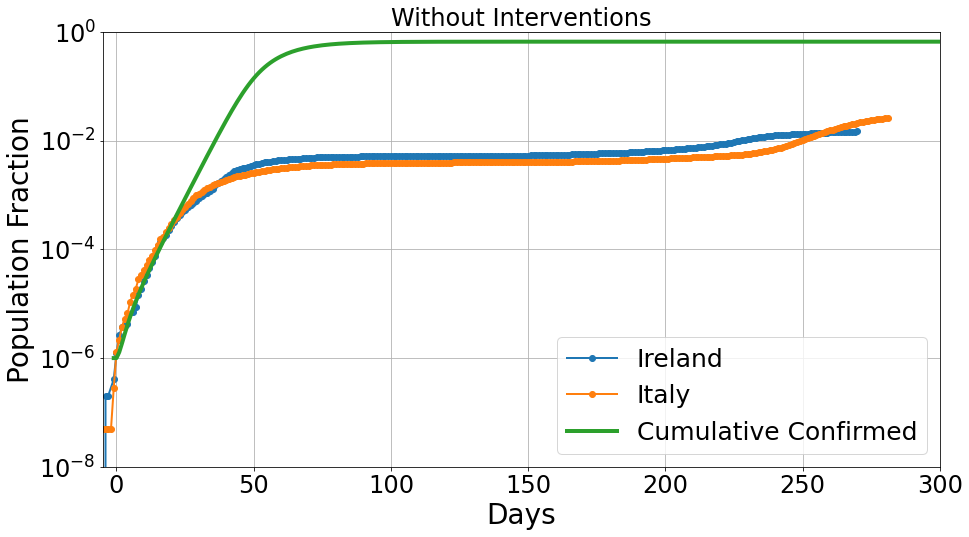

0.1
0.47189588102825386
0.1398172486997298
0.04993473167847484

0.06742542216417892
0.03965249160575077
0.014161604144910966


In [18]:
days = 1200   # Length of simulation
pop = 350e6
latent_period = 11  # Days. How long someone is asymptomatic.
R_nought = 2.8  # show sources/data
T = 0.1  # Estimate using test count, population, count pos/negatives. ROI test count 17thMarch == 1784 tests 223 cases

days_to_recov_mild = 14      # Average time of 14 days for Mild case until Recovery
days_to_recov_severe = 14     # Average time of 4 weeks (28 Days) until Recovery or Death. 
days_to_death_severe = 14
days_to_recov_critical = 14   # Average time of 4 weeks (28 Days) until Recovery or Death.
days_to_death_critcial = 14

# R_nought = Beta*Infectious_Period
# Infectious_Period = Latent_Period + Days_To_Recov_Mild
# Severe & Critical are assumed isolated
# B(Beta) = R_nought/(Latent_Period + Days_To_Recov_Mild)

beta = 0.28 #R_nought/(latent_period + days_to_recov_mild)

### Initial States ###### Initial States ###### Initial States ###### Initial States ###### Initial States ###

#M_C_0 = 5/pop

A_M_0 = 2e-5
S0 = 1 - A_M_0

A_S_0 = 0
A_C_0 = 0
M_U_0 = 0
M_C_0 = 1e-6
S_C_0 = 0
C_C_0 = 0
R_0 = 0
D_0 = 0


### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##

K_M = 1/latent_period   # Assuming latent period is the same for each severity. Probably not True.
K_S = 1/latent_period
K_C = 1/latent_period


G_M = 0.81  # Fraction of cases in each severity.
G_S = 0.14
G_C = 1 - G_S - G_M


R_M = 1/days_to_recov_mild

## CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ###
# As this model is currently configured the ratio of the rates gives the probabilities of Recovery and Death. 
# Recovery_Probability = R_S/(R_S + D_S)  
# This might not be true. 50% might survive and take 20 days in hospital. 50% die and take 10 days in hospital.
# Recovery_Probability = (1/20)/((1/20) + (1/10) = 33%. 


R_S = 1/days_to_recov_severe
R_C = 1/days_to_death_severe

D_S = 1/days_to_recov_critical
D_C = 1/days_to_death_critcial

#B = lambda t: R_nought/(latent_period + days_to_recov_mild) if (t < 100 or t > 150) else 0.01
# B = lambda t: 0.14 if (t < 15 or t > 40) else 0.0005
#B = lambda t: 0.28 #if (t < 15 or t > 40) else 0.0005
B = beta

sir = SI_IR(T, B, G_M, G_S, G_C, K_M, K_S, K_C, R_M, R_S, R_C, D_S, D_C,\
            S0, A_M_0, A_S_0, A_C_0, M_U_0, M_C_0, S_C_0, C_C_0, R_0, D_0) # Parameters & Initial States
solver = ForwardEuler(sir)
solver.set_initial_conditions(sir.initial_conditions)


time_steps = np.linspace(1, days, days)
u, t = solver.solve(time_steps)

MC_list = np.concatenate((np.zeros(1), u[:, 5]), axis=None)
SC_list = np.concatenate((np.zeros(1), u[:, 6]), axis=None)
CC_list = np.concatenate((np.zeros(1), u[:, 7]), axis=None)

MC_unique_count = []
SC_unique_count = []
CC_unique_count = []

for i in range(1, len(MC_list)):
    MC_unique_count.append(MC_list[i] - (MC_list[i-1]*(1 - R_M)))
    
for i in range(1, len(SC_list)):
    SC_unique_count.append(SC_list[i] - (SC_list[i-1]*(1 - R_S - D_S)))
    
for i in range(1, len(CC_list)):
    CC_unique_count.append(CC_list[i] - (CC_list[i-1]*(1 - R_C - D_C)))
    

conf_unique_count = np.add(np.add(MC_unique_count,SC_unique_count),CC_unique_count)

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.plot(x5, frxn5, label="Ireland", linewidth = 2, marker= 'o')
plt.plot(x2, frxn2, label="Italy", linewidth = 2, marker= 'o')
#plt.plot(x1, set1, label="USA", linewidth = 2, marker= 'o')
#plt.plot(x8, set8, label="Iran", linewidth = 2, marker= 'o')
plt.plot(t-2, np.cumsum(conf_unique_count), label="Cumulative Confirmed", linewidth = 4)
#plt.plot(t-1, np.cumsum(MC_unique_count), label="Cumulative MILD Confirmed", linewidth = 4)
#plt.plot(t-1, np.cumsum(SC_unique_count), label="Cumulative SEV Confirmed", linewidth = 4)
#plt.plot(t-1, np.cumsum(CC_unique_count), label="Cumulative CRIT Confirmed", linewidth = 4)

#y2 = 90000/5e6
#_ = plt.plot([0, 35], [13/5e6, y2], linewidth=4)  # number of cases

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Days', fontsize = 28)
plt.ylabel('Population Fraction', fontsize = 28)

plt.xlim(-5,300)
plt.ylim(1e-8,1e-0)
plt.yscale('log')
plt.title('Without Interventions', fontsize = 24)

plt.legend(fontsize = 25)
plt.grid(True)
plt.show()

print (T)
print (np.cumsum(MC_unique_count)[-1])
print (np.cumsum(SC_unique_count)[-1])
print (np.cumsum(CC_unique_count)[-1])
print ('')
print (np.cumsum(MC_unique_count)[50])
print (np.cumsum(SC_unique_count)[50])
print (np.cumsum(CC_unique_count)[50])

In [11]:
R_nought/(latent_period + days_to_recov_mild) 

0.11199999999999999

100%|##########| 1199/1199 [00:00<00:00, 44527.02it/s]


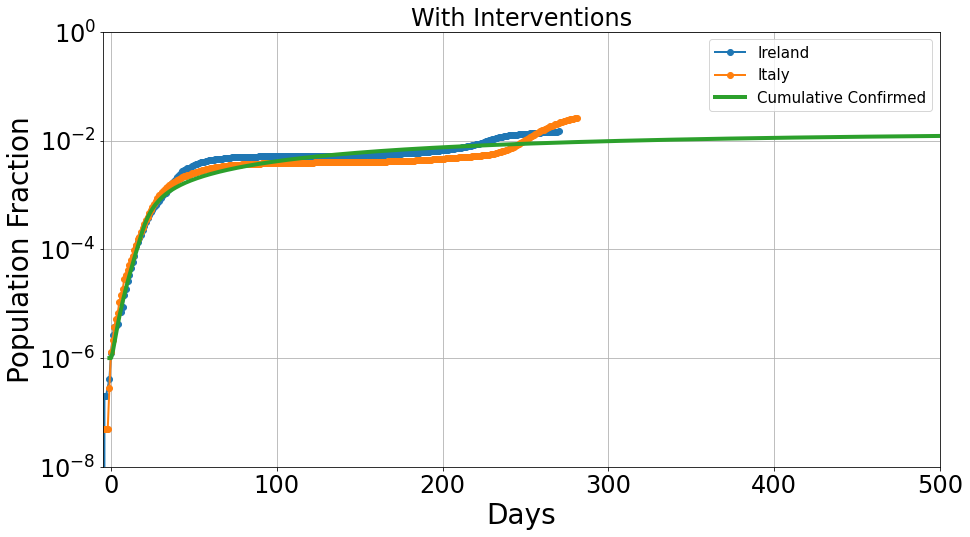

0.1
0.00985955954505307
0.00291800332554449
0.0010421440448373192

0.0012924963967037247
0.00044169353606496293
0.00015774769145177232


In [12]:
days = 1200   # Length of simulation
pop = 350e6
latent_period = 11  # Days. How long someone is asymptomatic.
R_nought = 2.8  # show sources/data
T = 0.1  # Estimate using test count, population, count pos/negatives. ROI test count 17thMarch == 1784 tests 223 cases

days_to_recov_mild = 14      # Average time of 14 days for Mild case until Recovery
days_to_recov_severe = 14     # Average time of 4 weeks (28 Days) until Recovery or Death. 
days_to_death_severe = 14
days_to_recov_critical = 14   # Average time of 4 weeks (28 Days) until Recovery or Death.
days_to_death_critcial = 14

# R_nought = Beta*Infectious_Period
# Infectious_Period = Latent_Period + Days_To_Recov_Mild
# Severe & Critical are assumed isolated
# B(Beta) = R_nought/(Latent_Period + Days_To_Recov_Mild)

beta = 0.28 #R_nought/(latent_period + days_to_recov_mild)

### Initial States ###### Initial States ###### Initial States ###### Initial States ###### Initial States ###

#M_C_0 = 5/pop

A_M_0 = 2e-5
S0 = 1 - A_M_0

A_S_0 = 0
A_C_0 = 0
M_U_0 = 0
M_C_0 = 1e-6
S_C_0 = 0
C_C_0 = 0
R_0 = 0
D_0 = 0


### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##

K_M = 1/latent_period   # Assuming latent period is the same for each severity. Probably not True.
K_S = 1/latent_period
K_C = 1/latent_period


G_M = 0.81  # Fraction of cases in each severity.
G_S = 0.14
G_C = 1 - G_S - G_M


R_M = 1/days_to_recov_mild

## CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ###
# As this model is currently configured the ratio of the rates gives the probabilities of Recovery and Death. 
# Recovery_Probability = R_S/(R_S + D_S)  
# This might not be true. 50% might survive and take 20 days in hospital. 50% die and take 10 days in hospital.
# Recovery_Probability = (1/20)/((1/20) + (1/10) = 33%. 


R_S = 1/days_to_recov_severe
R_C = 1/days_to_death_severe

D_S = 1/days_to_recov_critical
D_C = 1/days_to_death_critcial

beta = 0.28

B = lambda t: beta if (t < 20 or t > 1500) else beta*0.15
# B = lambda t: 0.14 if (t < 15 or t > 40) else 0.0005
# B = lambda t: 0.28 if (t < 20 or t > 60) else 0.28*0.55

sir = SI_IR(T, B, G_M, G_S, G_C, K_M, K_S, K_C, R_M, R_S, R_C, D_S, D_C,\
            S0, A_M_0, A_S_0, A_C_0, M_U_0, M_C_0, S_C_0, C_C_0, R_0, D_0) # Parameters & Initial States
solver = ForwardEuler(sir)
solver.set_initial_conditions(sir.initial_conditions)


time_steps = np.linspace(1, days, days)
u, t = solver.solve(time_steps)

MC_list = np.concatenate((np.zeros(1), u[:, 5]), axis=None)
SC_list = np.concatenate((np.zeros(1), u[:, 6]), axis=None)
CC_list = np.concatenate((np.zeros(1), u[:, 7]), axis=None)

MC_unique_count = []
SC_unique_count = []
CC_unique_count = []

for i in range(1, len(MC_list)):
    MC_unique_count.append(MC_list[i] - (MC_list[i-1]*(1 - R_M)))
    
for i in range(1, len(SC_list)):
    SC_unique_count.append(SC_list[i] - (SC_list[i-1]*(1 - R_S - D_S)))
    
for i in range(1, len(CC_list)):
    CC_unique_count.append(CC_list[i] - (CC_list[i-1]*(1 - R_C - D_C)))
    

conf_unique_count = np.add(np.add(MC_unique_count,SC_unique_count),CC_unique_count)

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.plot(x5, frxn5, label="Ireland", linewidth = 2, marker= 'o')
plt.plot(x2, frxn2, label="Italy", linewidth = 2, marker= 'o')
#plt.plot(x1, set1, label="USA", linewidth = 2, marker= 'o')
#plt.plot(x8, set8, label="Iran", linewidth = 2, marker= 'o')
plt.plot(t-2, np.cumsum(conf_unique_count), label="Cumulative Confirmed", linewidth = 4)
#plt.plot(t-1, np.cumsum(MC_unique_count), label="Cumulative MILD Confirmed", linewidth = 4)
#plt.plot(t-1, np.cumsum(SC_unique_count), label="Cumulative SEV Confirmed", linewidth = 4)
#plt.plot(t-1, np.cumsum(CC_unique_count), label="Cumulative CRIT Confirmed", linewidth = 4)

#y2 = 90000/5e6
#_ = plt.plot([0, 35], [13/5e6, y2], linewidth=4)  # number of cases

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Days', fontsize = 28)
plt.ylabel('Population Fraction', fontsize = 28)

plt.xlim(-5,500)
plt.ylim(1e-8,1e-0)
plt.yscale('log')
plt.title('With Interventions', fontsize = 24)

plt.legend(fontsize = 15)
plt.grid(True)
plt.show()

print (T)
print (np.cumsum(MC_unique_count)[-1])
print (np.cumsum(SC_unique_count)[-1])
print (np.cumsum(CC_unique_count)[-1])
print ('')
print (np.cumsum(MC_unique_count)[50])
print (np.cumsum(SC_unique_count)[50])
print (np.cumsum(CC_unique_count)[50])

In [13]:
eu[eu.COUNTRY == 'Ireland']

,COUNTRY,DATE,day,month,year,CASES,DEATHS,countryterritoryCode,POPULATION,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,CUM_CASES,CUM_DEATHS,INFECTED_CUM_FRXN,AT_LEAST_5_DAILY_CASES_DATE,DAYS_SINCE_5_INFXNS,AT_LEAST_1_in_1e6_infected,DAYS_SINCE_INFXN_START
26789,Ireland,2019-12-31,31,12,2019,0,0,IRL,4904240.0,Europe,NaN,0.0,0.0,0.000000,2020-03-06,-66.0,2020-03-05,-65.0
26790,Ireland,2020-01-01,1,1,2020,0,0,IRL,4904240.0,Europe,NaN,0.0,0.0,0.000000,2020-03-06,-65.0,2020-03-05,-64.0
26791,Ireland,2020-01-02,2,1,2020,0,0,IRL,4904240.0,Europe,NaN,0.0,0.0,0.000000,2020-03-06,-64.0,2020-03-05,-63.0
26792,Ireland,2020-01-03,3,1,2020,0,0,IRL,4904240.0,Europe,NaN,0.0,0.0,0.000000,2020-03-06,-63.0,2020-03-05,-62.0
26793,Ireland,2020-01-04,4,1,2020,0,0,IRL,4904240.0,Europe,NaN,0.0,0.0,0.000000,2020-03-06,-62.0,2020-03-05,-61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27118,Ireland,2020-11-26,26,11,2020,257,5,IRL,4904240.0,Europe,100.729165,71187.0,2033.0,0.014515,2020-03-06,265.0,2020-03-05,266.0
27119,Ireland,2020-11-27,27,11,2020,307,3,IRL,4904240.0,Europe,99.138704,71494.0,2036.0,0.014578,2020-03-06,266.0,2020-03-05,267.0
27120,Ireland,2020-11-28,28,11,2020,205,7,IRL,4904240.0,Europe,93.796388,71699.0,2043.0,0.014620,2020-03-06,267.0,2020-03-05,268.0
27121,Ireland,2020-11-29,29,11,2020,243,7,IRL,4904240.0,Europe,90.044533,71942.0,2050.0,0.014669,2020-03-06,268.0,2020-03-05,269.0


100%|##########| 1199/1199 [00:00<00:00, 48089.15it/s]


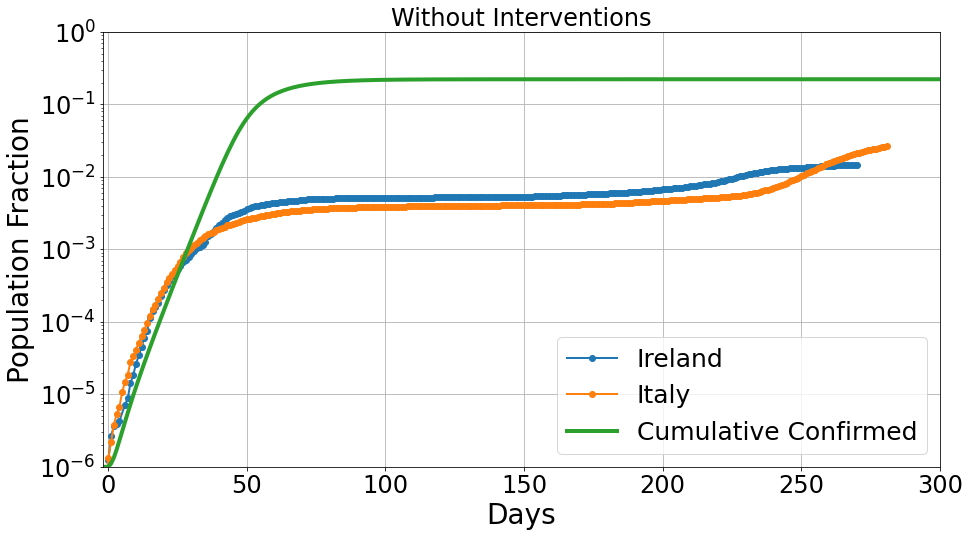

In [19]:
days = 1200   # Length of simulation
pop = 5e6
pop2 = 60e6
latent_period = 11  # Days. How long someone is asymptomatic.
R_nought = 1.8  # show sources/data
T = 0.003  # Estimate using test count, population, count pos/negatives. ROI test count 17thMarch == 1784 tests 223 cases

days_to_recov_mild = 14       # Average time of 14 days for Mild case until Recovery
days_to_recov_severe = 28     # Average time of 4 weeks (28 Days) until Recovery or Death. 
days_to_death_severe = 28
days_to_recov_critical = 28   # Average time of 4 weeks (28 Days) until Recovery or Death.
days_to_death_critcial = 28


### Initial States ###### Initial States ###### Initial States ###### Initial States ###### Initial States ###

#M_C_0 = 5/pop

A_M_0 = 2e-5
S0 = 1 - A_M_0

A_S_0 = 0
A_C_0 = 0
M_U_0 = 0
M_C_0 = 1e-6
S_C_0 = 0
C_C_0 = 0
R_0 = 0
D_0 = 0


### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##


K_M = 1/latent_period   # Assuming latent period is the same for each severity. Probably not True.
K_S = 1/latent_period
K_C = 1/latent_period

# R_nought = Beta*Infectious_Period
# Infectious_Period = Latent_Period + Days_To_Recov_Mild
# Severe & Critical are assumed isolated
# B(Beta) = R_nought/(Latent_Period + Days_To_Recov_Mild)
#B = R_nought/(latent_period + days_to_recov_mild)

beta = 0.28
B = beta

G_M = 0.81  # Fraction of cases in each severity.
G_S = 0.14
G_C = 0.05


R_M = 1/days_to_recov_mild

## CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ###
# As this model is currently configured the ratio of the rates gives the probabilities of Recovery and Death. 
# Recovery_Probability = R_S/(R_S + D_S)  
# This might not be true. 50% might survive and take 20 days in hospital. 50% die and take 10 days in hospital.
# Recovery_Probability = (1/20)/((1/20) + (1/10) = 33%. 


R_S = 1/days_to_recov_severe
R_C = 1/days_to_death_severe

D_S = 1/days_to_recov_critical
D_C = 1/days_to_death_critcial

#B = lambda t: R_nought/(latent_period + days_to_recov_mild) if (t < 100 or t > 150) else 0.01
# B = lambda t: 0.14 if (t < 15 or t > 40) else 0.0005
B = lambda t: 0.28 #if (t < 15 or t > 40) else 0.0005

sir = SI_IR(T, B, G_M, G_S, G_C, K_M, K_S, K_C, R_M, R_S, R_C, D_S, D_C,\
            S0, A_M_0, A_S_0, A_C_0, M_U_0, M_C_0, S_C_0, C_C_0, R_0, D_0) # Parameters & Initial States
solver = ForwardEuler(sir)
solver.set_initial_conditions(sir.initial_conditions)


time_steps = np.linspace(1, days, days)
u, t = solver.solve(time_steps)

MC_list = np.concatenate((np.zeros(1), u[:, 5]), axis=None)
SC_list = np.concatenate((np.zeros(1), u[:, 6]), axis=None)
CC_list = np.concatenate((np.zeros(1), u[:, 7]), axis=None)

MC_unique_count = []
SC_unique_count = []
CC_unique_count = []

for i in range(1, len(MC_list)):
    MC_unique_count.append(MC_list[i] - (MC_list[i-1]*(1 - R_M)))
    
for i in range(1, len(SC_list)):
    SC_unique_count.append(SC_list[i] - (SC_list[i-1]*(1 - R_S - D_S)))
    
for i in range(1, len(CC_list)):
    CC_unique_count.append(CC_list[i] - (CC_list[i-1]*(1 - R_C - D_C)))
    
conf_unique_count = np.add(np.add(MC_unique_count,SC_unique_count),CC_unique_count)

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.plot(x5, frxn5, label="Ireland", linewidth = 2, marker= 'o')
plt.plot(x2, frxn2, label="Italy", linewidth = 2, marker= 'o')
plt.plot(t-2, np.cumsum(conf_unique_count), label="Cumulative Confirmed", linewidth = 4)

#y2 = 90000/5e6
#_ = plt.plot([0, 35], [13/5e6, y2], linewidth=4)  # number of cases

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Days', fontsize = 28)
plt.ylabel('Population Fraction', fontsize = 28)

plt.xlim(-2,300)
plt.ylim(1e-6,1)
plt.yscale('log')
plt.title('Without Interventions', fontsize = 24)

plt.legend(fontsize = 25)
plt.grid(True)
plt.show()

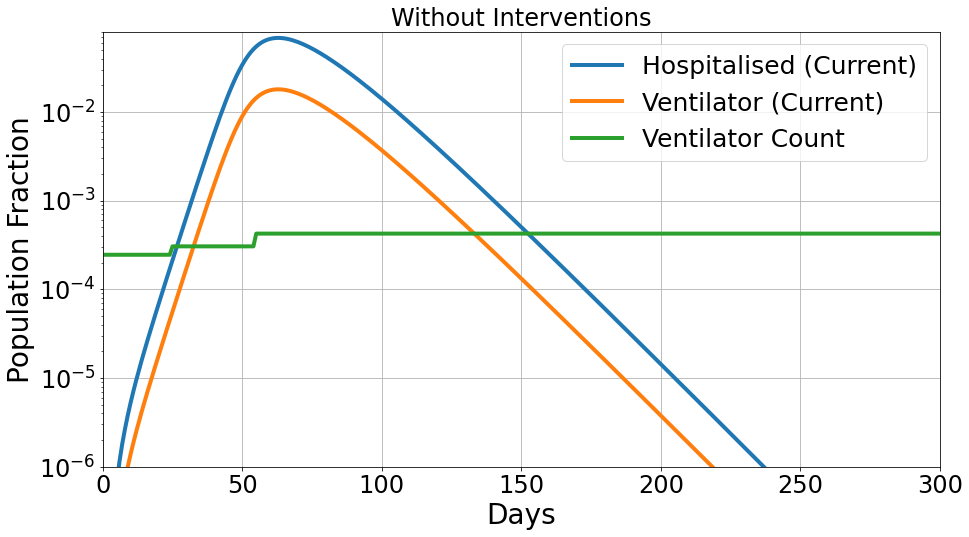

In [22]:
Ven = lambda x: 1229 if x< 24 else(1529 if x<54 else 2129)

ven_list = []
for x in range(1200):
    ven_list.append(Ven(x))


fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Days', fontsize = 28)
plt.ylabel('Population Fraction', fontsize = 28)

plt.xlim(-2,days)
#plt.ylim(0.00000001,1)
#plt.yscale('log')

#plt.plot(t, u[:, 0], label="Susceptible")
#plt.plot(t, u[:, 1], label="Latent Mild")
#plt.plot(t, u[:, 2], label="Latent Severe")
#plt.plot(t, u[:, 3], label="Latent Critical")
#plt.plot(t, u[:, 2] + u[:, 3], label="Latent Hospitalistions (Current)", linewidth = 4)
#plt.plot(t, u[:, 4], label="Mild Unconfirmed")
#plt.plot(t, u[:, 5], label="Mild Confirmed")
#plt.plot(t, u[:, 6], label="Severe")
#plt.plot(t, u[:, 7], label="Critical")
plt.plot(t, u[:, 6] + u[:, 7], label="Hospitalised (Current)", linewidth = 4)
plt.plot(t, u[:, 7], label="Ventilator (Current)", linewidth = 4)
plt.plot(t, np.divide(ven_list,pop), label="Ventilator Count", linewidth = 4)
#plt.plot(t, u[:, 9], label="Dead")
#plt.plot(t-1, np.cumsum(conf_unique_count), label="Confirmed (Cumulative)", linewidth = 4)

#_ = plt.plot([-10, 3500], [1000/pop, 1000/pop], linewidth=2)  # number of ventilators
#_ = plt.plot([-10, 3500], [1229/pop, 1229/pop], linewidth=2)  # number of ventilators
plt.legend(fontsize = 25)
plt.title('Without Interventions', fontsize = 24)

plt.xlim(0,300)
plt.ylim(1e-6, 0.08)
plt.yscale('log')
plt.grid(True)
plt.show()

In [13]:
eu[eu.COUNTRY == 'Ireland']

,COUNTRY,DATE,day,month,year,CASES,DEATHS,countryterritoryCode,POPULATION,continentExp,CUM_CASES,CUM_DEATHS,INFECTED_CUM_FRXN,AT_LEAST_5_DAILY_CASES_DATE,DAYS_SINCE_5_INFXNS,AT_LEAST_1_in_1e6_infected,DAYS_SINCE_INFXN_START
6651,Ireland,2019-12-31,31,12,2019,0,0,IRL,4853506.0,Europe,0.0,0.0,0.000000e+00,2020-03-06,-66.0,2020-03-05,-65.0
6652,Ireland,2020-01-01,1,1,2020,0,0,IRL,4853506.0,Europe,0.0,0.0,0.000000e+00,2020-03-06,-65.0,2020-03-05,-64.0
6653,Ireland,2020-01-02,2,1,2020,0,0,IRL,4853506.0,Europe,0.0,0.0,0.000000e+00,2020-03-06,-64.0,2020-03-05,-63.0
6654,Ireland,2020-01-03,3,1,2020,0,0,IRL,4853506.0,Europe,0.0,0.0,0.000000e+00,2020-03-06,-63.0,2020-03-05,-62.0
6655,Ireland,2020-01-04,4,1,2020,0,0,IRL,4853506.0,Europe,0.0,0.0,0.000000e+00,2020-03-06,-62.0,2020-03-05,-61.0
6656,Ireland,2020-01-05,5,1,2020,0,0,IRL,4853506.0,Europe,0.0,0.0,0.000000e+00,2020-03-06,-61.0,2020-03-05,-60.0
6657,Ireland,2020-01-06,6,1,2020,0,0,IRL,4853506.0,Europe,0.0,0.0,0.000000e+00,2020-03-06,-60.0,2020-03-05,-59.0
6658,Ireland,2020-01-07,7,1,2020,0,0,IRL,4853506.0,Europe,0.0,0.0,0.000000e+00,2020-03-06,-59.0,2020-03-05,-58.0
6659,Ireland,2020-01-08,8,1,2020,0,0,IRL,4853506.0,Europe,0.0,0.0,0.000000e+00,2020-03-06,-58.0,2020-03-05,-57.0
6660,Ireland,2020-01-09,9,1,2020,0,0,IRL,4853506.0,Europe,0.0,0.0,0.000000e+00,2020-03-06,-57.0,2020-03-05,-56.0


# With Intervention

100%|##########| 1199/1199 [00:00<00:00, 44527.02it/s]


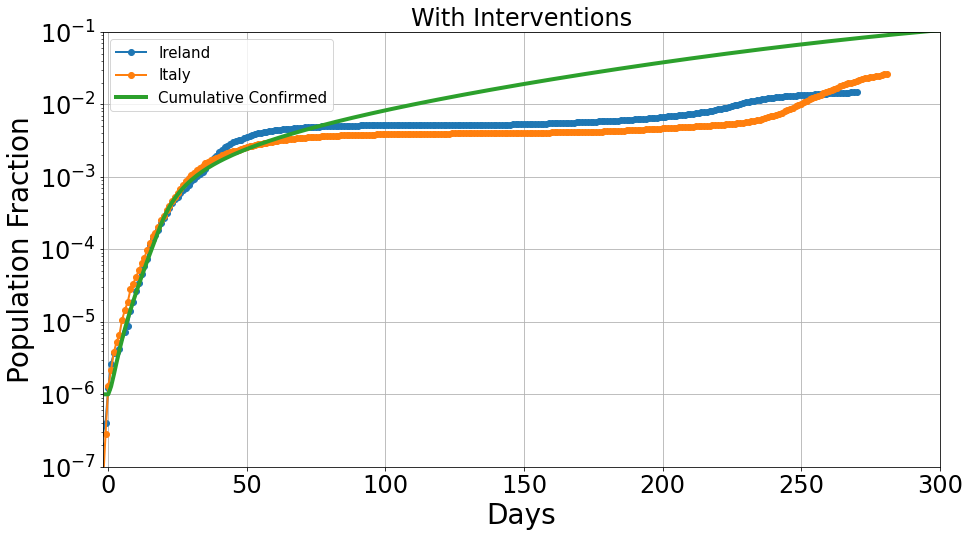

0.1
0.17828668625668792
0.052821992408109426
0.018864997288610522

0.0015761958933478283
0.0005643515800233923
0.00020155413572263983


In [25]:
days = 1200   # Length of simulation
pop = 350e6
latent_period = 11  # Days. How long someone is asymptomatic.
R_nought = 2.8  # show sources/data
T = 0.1  # Estimate using test count, population, count pos/negatives. ROI test count 17thMarch == 1784 tests 223 cases

days_to_recov_mild = 14      # Average time of 14 days for Mild case until Recovery
days_to_recov_severe = 14     # Average time of 4 weeks (28 Days) until Recovery or Death. 
days_to_death_severe = 14
days_to_recov_critical = 14   # Average time of 4 weeks (28 Days) until Recovery or Death.
days_to_death_critcial = 14

# R_nought = Beta*Infectious_Period
# Infectious_Period = Latent_Period + Days_To_Recov_Mild
# Severe & Critical are assumed isolated
# B(Beta) = R_nought/(Latent_Period + Days_To_Recov_Mild)

beta = 0.28 #R_nought/(latent_period + days_to_recov_mild)

### Initial States ###### Initial States ###### Initial States ###### Initial States ###### Initial States ###

#M_C_0 = 5/pop

A_M_0 = 2e-5
S0 = 1 - A_M_0

A_S_0 = 0
A_C_0 = 0
M_U_0 = 0
M_C_0 = 1e-6
S_C_0 = 0
C_C_0 = 0
R_0 = 0
D_0 = 0


### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##

K_M = 1/latent_period   # Assuming latent period is the same for each severity. Probably not True.
K_S = 1/latent_period
K_C = 1/latent_period


G_M = 0.81  # Fraction of cases in each severity.
G_S = 0.14
G_C = 1 - G_S - G_M


R_M = 1/days_to_recov_mild

## CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ###
# As this model is currently configured the ratio of the rates gives the probabilities of Recovery and Death. 
# Recovery_Probability = R_S/(R_S + D_S)  
# This might not be true. 50% might survive and take 20 days in hospital. 50% die and take 10 days in hospital.
# Recovery_Probability = (1/20)/((1/20) + (1/10) = 33%. 


R_S = 1/days_to_recov_severe
R_C = 1/days_to_death_severe

D_S = 1/days_to_recov_critical
D_C = 1/days_to_death_critcial

beta = 0.28

B = lambda t: beta if (t < 20 or t > 1500) else beta*0.2
# B = lambda t: 0.14 if (t < 15 or t > 40) else 0.0005
# B = lambda t: 0.28 if (t < 20 or t > 60) else 0.28*0.55

sir = SI_IR(T, B, G_M, G_S, G_C, K_M, K_S, K_C, R_M, R_S, R_C, D_S, D_C,\
            S0, A_M_0, A_S_0, A_C_0, M_U_0, M_C_0, S_C_0, C_C_0, R_0, D_0) # Parameters & Initial States
solver = ForwardEuler(sir)
solver.set_initial_conditions(sir.initial_conditions)


time_steps = np.linspace(1, days, days)
u, t = solver.solve(time_steps)

MC_list = np.concatenate((np.zeros(1), u[:, 5]), axis=None)
SC_list = np.concatenate((np.zeros(1), u[:, 6]), axis=None)
CC_list = np.concatenate((np.zeros(1), u[:, 7]), axis=None)

MC_unique_count = []
SC_unique_count = []
CC_unique_count = []

for i in range(1, len(MC_list)):
    MC_unique_count.append(MC_list[i] - (MC_list[i-1]*(1 - R_M)))
    
for i in range(1, len(SC_list)):
    SC_unique_count.append(SC_list[i] - (SC_list[i-1]*(1 - R_S - D_S)))
    
for i in range(1, len(CC_list)):
    CC_unique_count.append(CC_list[i] - (CC_list[i-1]*(1 - R_C - D_C)))
    

conf_unique_count = np.add(np.add(MC_unique_count,SC_unique_count),CC_unique_count)

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.plot(x5, frxn5, label="Ireland", linewidth = 2, marker= 'o')
plt.plot(x2, frxn2, label="Italy", linewidth = 2, marker= 'o')
#plt.plot(x1, set1, label="USA", linewidth = 2, marker= 'o')
#plt.plot(x8, set8, label="Iran", linewidth = 2, marker= 'o')
plt.plot(t-2, np.cumsum(conf_unique_count), label="Cumulative Confirmed", linewidth = 4)
#plt.plot(t-1, np.cumsum(MC_unique_count), label="Cumulative MILD Confirmed", linewidth = 4)
#plt.plot(t-1, np.cumsum(SC_unique_count), label="Cumulative SEV Confirmed", linewidth = 4)
#plt.plot(t-1, np.cumsum(CC_unique_count), label="Cumulative CRIT Confirmed", linewidth = 4)

#y2 = 90000/5e6
#_ = plt.plot([0, 35], [13/5e6, y2], linewidth=4)  # number of cases

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Days', fontsize = 28)
plt.ylabel('Population Fraction', fontsize = 28)

plt.xlim(-2,300)
plt.ylim(1e-7,1e-1)
plt.yscale('log')
plt.title('With Interventions', fontsize = 24)

plt.legend(fontsize = 15)
plt.grid(True)
plt.show()

print (T)
print (np.cumsum(MC_unique_count)[-1])
print (np.cumsum(SC_unique_count)[-1])
print (np.cumsum(CC_unique_count)[-1])
print ('')
print (np.cumsum(MC_unique_count)[50])
print (np.cumsum(SC_unique_count)[50])
print (np.cumsum(CC_unique_count)[50])

In [26]:
hosp=[np.nan,   np.nan,   np.nan, np.nan,np.nan,   np.nan,   np.nan, np.nan,   np.nan,  np.nan, np.nan,   np.nan, 
      np.nan,   np.nan,   np.nan, np.nan,np.nan,   np.nan,   np.nan, np.nan,   np.nan,  np.nan, np.nan,   np.nan, 
    np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan, np.nan,
     np.nan,   np.nan,  np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,
     np.nan,   np.nan,  np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,
     np.nan,   np.nan,  np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,
     np.nan,   np.nan,  np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,
     np.nan,   np.nan,  np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,
     np.nan,   np.nan,  np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,  
     np.nan,   np.nan,  np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,
         np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   84.,  108.,
        140.,  173.,  211.,  239.,  277.,  305.,  340.,  419.,  489.,
        564.,  645.,  703.,  834.,  932., 1039., 1118., 1203., 1265.]

icu=[np.nan,   np.nan,   np.nan, np.nan,np.nan,   np.nan,   np.nan, np.nan,   np.nan,  np.nan, np.nan,   np.nan, 
     np.nan,   np.nan,   np.nan, np.nan,np.nan,   np.nan,   np.nan, np.nan,   np.nan,   np.nan, np.nan,   np.nan,  
    np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan, np.nan,
     np.nan,   np.nan,  np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,
     np.nan,   np.nan,  np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,
     np.nan,   np.nan,  np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,
     np.nan,   np.nan,  np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,
     np.nan,   np.nan,  np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,  
     np.nan,   np.nan,  np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan,   np.nan, 
    np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan,
        np.nan,  np.nan,  np.nan,  np.nan,  np.nan,   6.,   7.,  12.,  13.,  17.,  25.,
        36.,  39.,  47.,  59.,  67.,  77.,  84., 113., 126., 134., 148.,
       158., 165., 169.]

ValueError: x and y must have same first dimension, but have shapes (334,) and (122,)

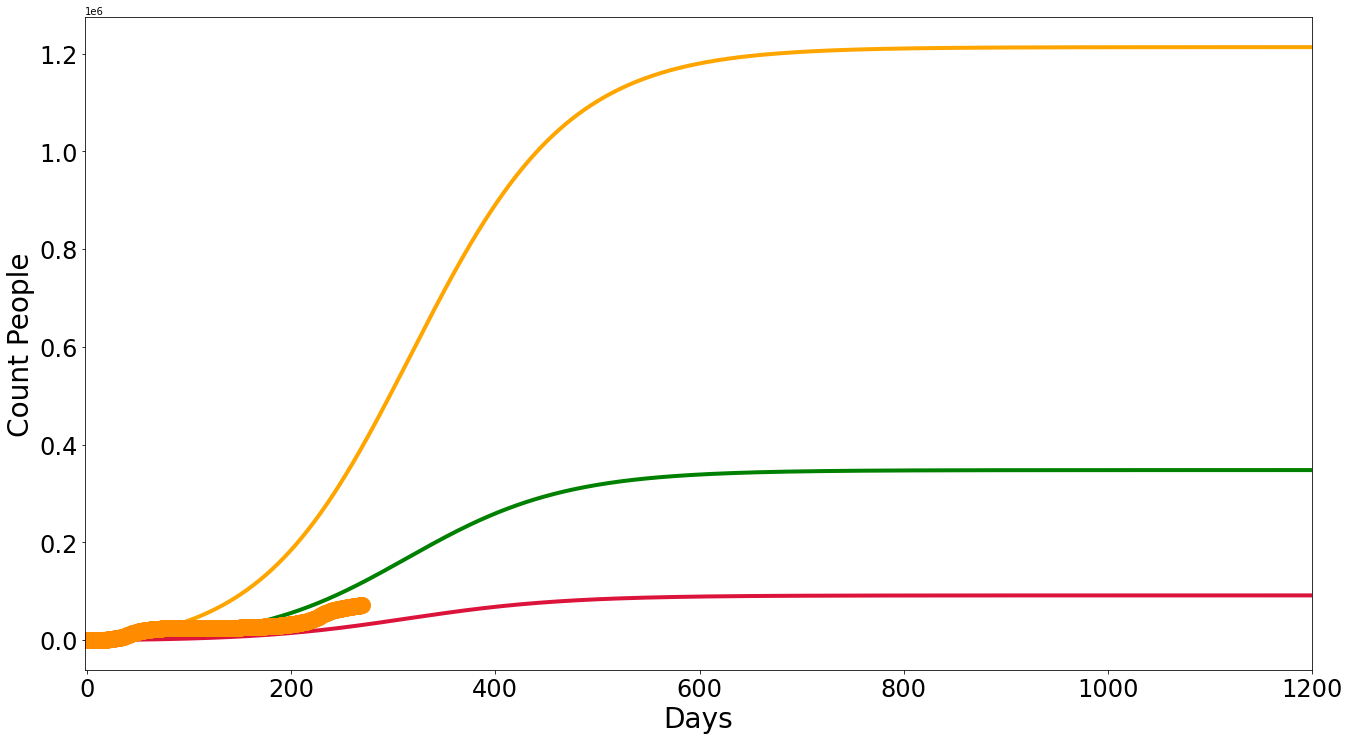

In [27]:
Ven = lambda x: 1229 if x< 24 else(1529 if x<54 else 2129)

ven_list = []
for x in range(1200):
    ven_list.append(Ven(x))

    
pop = 4853506.0

fig, ax = plt.subplots()
fig.set_size_inches(22, 12, forward=True)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Days', fontsize = 28)
plt.ylabel('Count People', fontsize = 28)

plt.xlim(-2,days)
#plt.ylim(0.00000001,1)
#plt.yscale('log')

#plt.plot(t, u[:, 0], label="Susceptible")
#plt.plot(t, u[:, 1], label="Latent Mild")
#plt.plot(t, u[:, 2], label="Latent Severe")
#plt.plot(t, u[:, 3], label="Latent Critical")
#plt.plot(t, u[:, 2] + u[:, 3], label="Latent Hospitalistions (Current)", linewidth = 4)
#plt.plot(t, u[:, 4], label="Mild Unconfirmed")
#plt.plot(t, u[:, 5], label="Mild Confirmed")
#plt.plot(t, u[:, 6], label="Severe")
#plt.plot(t, u[:, 7], label="Critical")
#plt.plot(t-2, (u[:, 5] + u[:, 6] + u[:, 7])*pop, label="Confirmed (Current)", linewidth = 4)
#plt.plot(t-2, (u[:, 6] + u[:, 7])*pop, label="Hospitalised (Current)", linewidth = 4)
#plt.plot(t-2, (u[:, 7])*pop, label="Critical (Current)", linewidth = 4)

plt.plot(t-2, np.cumsum(conf_unique_count)*pop, 
         label="Confirmed    (Cumulative)", 
         color = 'orange',
         linewidth = 4)

plt.plot(t-2, np.cumsum(np.add(CC_unique_count,SC_unique_count))*pop, 
         label="Hospitalised (Cumulative)", 
         color = 'green',
         linewidth = 4)

plt.plot(t-2, np.cumsum(CC_unique_count)*pop, 
         label="Critical         (Cumulative)", 
         color = 'crimson',
         linewidth = 4)

plt.plot(x5, frxn5*pop, color = 'darkorange', linewidth = 6, marker= 'o', markersize=16)
plt.plot(x5-18, hosp,    color = 'darkgreen',  linewidth = 6, marker= 'o', markersize=16)
plt.plot(x5-18, icu,     color = 'tab:red',    linewidth = 6, marker= 'o', markersize=16)



_ = plt.plot([-8, 35.5], [1, 100000], linewidth=3, label = 'Without Intervention')  # number of ventilators




plt.plot(t-2, np.divide(ven_list,pop)*pop, label="Ventilator Count", linewidth = 4, color = 'dimgray')

#_ = plt.plot([-10, 3500], [1000/pop, 1000/pop], linewidth=2)  # number of ventilators
#_ = plt.plot([-10, 3500], [1229/pop, 1229/pop], linewidth=2)  # number of ventilators
plt.legend(fontsize = 25)
plt.title('With Interventions', fontsize = 24)

plt.xlim(-2,60)
plt.ylim(8e0, 7e4)
plt.yscale('log')
plt.grid(True)
plt.show()

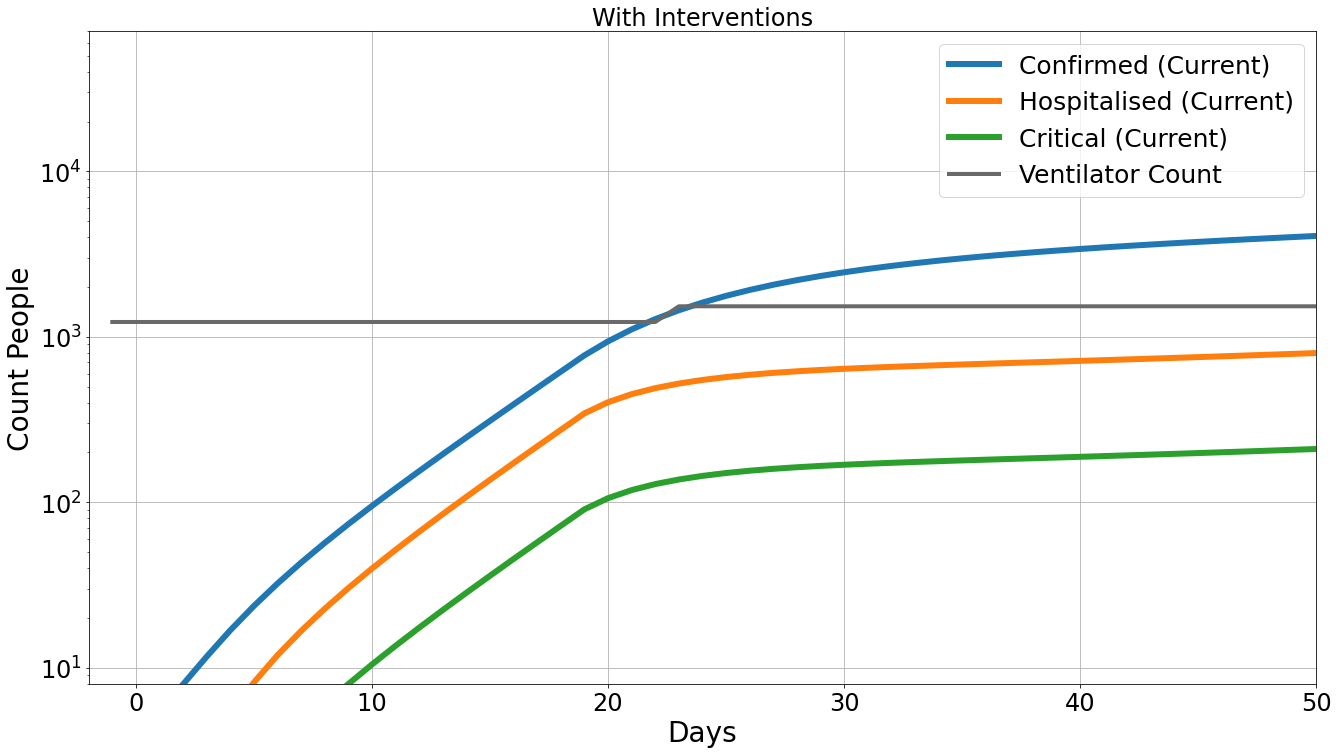

In [28]:
Ven = lambda x: 1229 if x< 24 else(1529 if x<54 else 2129)

ven_list = []
for x in range(1200):
    ven_list.append(Ven(x))

    
pop = 4853506.0

fig, ax = plt.subplots()
fig.set_size_inches(22, 12, forward=True)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Days', fontsize = 28)
plt.ylabel('Count People', fontsize = 28)

plt.xlim(-2,days)
#plt.ylim(0.00000001,1)
#plt.yscale('log')

#plt.plot(t, u[:, 0], label="Susceptible")
#plt.plot(t, u[:, 1], label="Latent Mild")
#plt.plot(t, u[:, 2], label="Latent Severe")
#plt.plot(t, u[:, 3], label="Latent Critical")
#plt.plot(t, u[:, 2] + u[:, 3], label="Latent Hospitalistions (Current)", linewidth = 4)
#plt.plot(t, u[:, 4], label="Mild Unconfirmed")
#plt.plot(t, u[:, 5], label="Mild Confirmed")
#plt.plot(t, u[:, 6], label="Severe")
#plt.plot(t, u[:, 7], label="Critical")
plt.plot(t-2, (u[:, 5] + u[:, 6] + u[:, 7])*pop, label="Confirmed (Current)", linewidth = 6)
plt.plot(t-2, (u[:, 6] + u[:, 7])*pop, label="Hospitalised (Current)", linewidth = 6)
plt.plot(t-2, (u[:, 7])*pop, label="Critical (Current)", linewidth = 6)
plt.plot(t-2, np.divide(ven_list,pop)*pop, label="Ventilator Count", linewidth = 4, color = 'dimgray')
#plt.plot(x5, frxn5*pop, label="Ireland", linewidth = 2, marker= 'o')
#plt.plot(t-2, np.cumsum(conf_unique_count)*pop, label="Confirmed (Cumulative)", linewidth = 4)
#plt.plot(t-2, np.cumsum(np.add(CC_unique_count,SC_unique_count))*pop, label="Hospitalised (Cumulative)", linewidth = 4)
#plt.plot(x5-3, hosp, marker= 'o')
#plt.plot(x5-3, icu, marker= 'o')


#_ = plt.plot([-10, 3500], [1000/pop, 1000/pop], linewidth=2)  # number of ventilators
#_ = plt.plot([-10, 3500], [1229/pop, 1229/pop], linewidth=2)  # number of ventilators
plt.legend(fontsize = 25)
plt.title('With Interventions', fontsize = 24)

plt.xlim(-2,50)
plt.ylim(8e0, 7e4)
plt.yscale('log')
plt.grid(True)
plt.show()

In [29]:
(np.cumsum(np.add(CC_unique_count,SC_unique_count))*pop).tolist()[25]

1043.0311376592215

In [30]:
frxn5*pop

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [31]:
(np.cumsum(conf_unique_count)*pop).tolist()

[4.853505999999999,
 4.853505999999999,
 6.228891496041994,
 9.04983038423876,
 13.461000912942236,
 19.689107420998784,
 28.054474836574155,
 38.98734210718246,
 53.04970604860945,
 70.96384291487823,
 93.64896877229401,
 122.26790783529017,
 158.28614020802144,
 203.5462213481707,
 260.36133487658964,
 331.6326945936043,
 420.99669519325084,
 533.0091780482074,
 673.3759932612404,
 849.2412787289492,
 1069.5476308699429,
 1315.3212081490917,
 1581.170408236955,
 1862.8388460381877,
 2156.9865586201117,
 2461.011632529891,
 2772.9049744059716,
 3091.1322355602,
 3414.5379648464514,
 3742.2679410077153,
 4073.7063583534978,
 4408.425134967063,
 4746.143102913429,
 5086.693243488942,
 5429.996462603195,
 5776.040674454756,
 6124.864186111085,
 6476.542559982178,
 6831.178282547258,
 7188.892691880843,
 7549.8197183368275,
 7914.101076152626,
 8281.882612000261,
 8653.311572333781,
 9028.53459698404,
 9407.69628366318,
 9790.938198368982,
 10178.39823136425,
 10570.21021846913,
 10966.50

In [33]:
x5

array([-65., -64., -63., -62., -61., -60., -59., -58., -57., -56., -55.,
       -54., -53., -52., -51., -50., -49., -48., -47., -46., -45., -44.,
       -43., -42., -41., -40., -39., -38., -37., -36., -35., -34., -33.,
       -32., -31., -30., -29., -28., -27., -26., -25., -24., -23., -22.,
       -21., -20., -19., -18., -17., -16., -15., -14., -13., -12., -11.,
       -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -1.,   0.,   1.,
         2.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  8

In [34]:
((u[:, 6] + u[:, 7])*pop).tolist()[25]

548.6733814606964

In [35]:
0.14*0.25

0.035

100%|##########| 1199/1199 [00:00<00:00, 41479.12it/s]


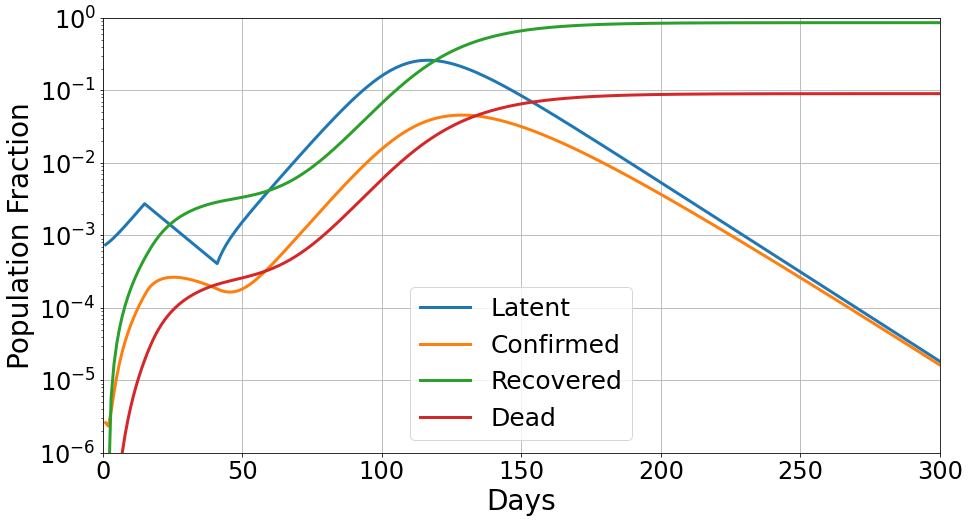

In [37]:
# nu is given by time taken to recover. It's 14 days, so every day there's a 1/14 chance of recovering
# We know R_nought is about 1.5. R_nought = beta/nu => beta = R_nought*nu = 1.5*0.07 = 0.1


#beta = lambda t: 0.2 #if t <=10 else 0.0001

days = 1200
pop = 5e6
latent_period = 14  # Days. How long someone is asymptomatic.
R_nought = 1.8  # show sources/data
T = 0.0035  # do we know the test count and then use population   ROI test count 17thMarch == 1784 tests 223 cases

days_to_recov_mild = 10       # Average time of 14 days for Mild case until Recovery
days_to_recov_severe = 28     # Average time of 4 weeks (28 Days) until Recovery or Death. 
days_to_death_severe = 28
days_to_recov_critical = 28   # Average time of 4 weeks (28 Days) until Recovery or Death.
days_to_death_critcial = 28


### Initial States ###### Initial States ###### Initial States ###### Initial States ###### Initial States ###

M_C_0 = 13/pop
S0 = 1 - M_C_0

A_M_0 = M_C_0/T
A_S_0 = 0
A_C_0 = 0
M_U_0 = 0

S_C_0 = 0
C_C_0 = 0
R_0 = 0
D_0 = 0


### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##### Parameters ##


K_M = 1/latent_period   # Assuming latent period is the same for each severity. Probably not True.
K_S = 1/latent_period
K_C = 1/latent_period

# R_nought = Beta*Infectious_Period
# Infectious_Period = Latent_Period + Days_To_Recov_Mild
# Severe & Critical are assumed isolated
# B(Beta) = R_nought/(Latent_Period + Days_To_Recov_Mild)
B = R_nought/(latent_period + days_to_recov_mild)

G_M = 0.81  # Fraction of cases in each severity.
G_S = 0.14
G_C = 0.05


R_M = 1/days_to_recov_mild

## CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ##### CAUTION!!!  ###
# As this model is currently configured the ratio of the rates gives the probabilities of Recovery and Death. 
# Recovery_Probability = R_S/(R_S + D_S)  
# This might not be true. 50% might survive and take 20 days in hospital. 50% die and take 10 days in hospital.
# Recovery_Probability = (1/20)/((1/20) + (1/10) = 33%. 


R_S = 1/days_to_recov_severe
R_C = 1/days_to_death_severe

D_S = 1/days_to_recov_critical
D_C = 1/days_to_death_critcial

#B = lambda t: R_nought/(latent_period + days_to_recov_mild) if (t < 100 or t > 150) else 0.01
B = lambda t: 0.14 if (t < 15 or t > 40) else 0.0005

sir = SI_IR(T, B, G_M, G_S, G_C, K_M, K_S, K_C, R_M, R_S, R_C, D_S, D_C,\
            S0, A_M_0, A_S_0, A_C_0, M_U_0, M_C_0, S_C_0, C_C_0, R_0, D_0) # Parameters & Initial States
solver = ForwardEuler(sir)
solver.set_initial_conditions(sir.initial_conditions)


time_steps = np.linspace(1, days, days)
u, t = solver.solve(time_steps)

MC_list = np.concatenate((np.zeros(1), u[:, 5]), axis=None)
SC_list = np.concatenate((np.zeros(1), u[:, 6]), axis=None)
CC_list = np.concatenate((np.zeros(1), u[:, 7]), axis=None)

MC_unique_count = []
SC_unique_count = []
CC_unique_count = []

for i in range(1, len(MC_list)):
    MC_unique_count.append(MC_list[i] - (MC_list[i-1]*(1 - R_M)))
    
for i in range(1, len(SC_list)):
    SC_unique_count.append(SC_list[i] - (SC_list[i-1]*(1 - R_S - D_S)))
    
for i in range(1, len(CC_list)):
    CC_unique_count.append(CC_list[i] - (CC_list[i-1]*(1 - R_C - D_C)))
    
conf_unique_count = np.add(np.add(MC_unique_count,SC_unique_count),CC_unique_count)

fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Days', fontsize = 28)
plt.ylabel('Population Fraction', fontsize = 28)

plt.xlim(-2,days)
#plt.ylim(0.00000001,1)
#plt.yscale('log')

#plt.plot(t, u[:, 0], label="Susceptible")
#plt.plot(t, u[:, 1], label="Latent Mild")
#plt.plot(t, u[:, 2], label="Latent Severe")
#plt.plot(t, u[:, 3], label="Latent Critical")
plt.plot(t, u[:, 1] + u[:, 2] + u[:, 3], label="Latent", linewidth=3)
#plt.plot(t, u[:, 4], label="Mild Unconfirmed")
#plt.plot(t, u[:, 5], label="Mild Confirmed")
#plt.plot(t, u[:, 6], label="Severe")
#plt.plot(t, u[:, 7], label="Critical")
plt.plot(t, u[:, 5] + u[:, 6] + u[:, 7], label="Confirmed", linewidth=3)
plt.plot(t, u[:, 8], label="Recovered", linewidth=3)
plt.plot(t, u[:, 9], label="Dead", linewidth=3)
plt.legend(fontsize = 25)


plt.xlim(0,300)
plt.ylim(10e-7, 1)
plt.yscale('log')
plt.grid(True)
plt.show()

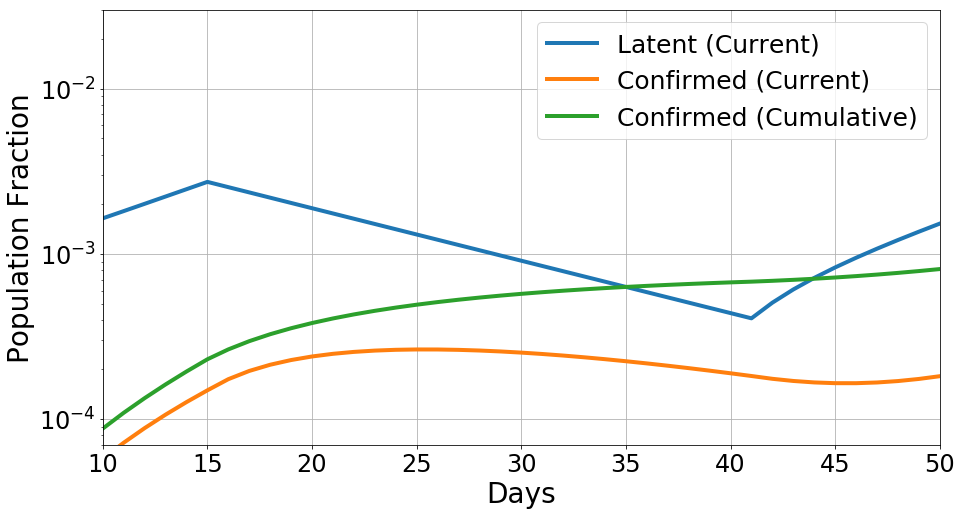

In [96]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Days', fontsize = 28)
plt.ylabel('Population Fraction', fontsize = 28)

plt.xlim(-2,days)
#plt.ylim(0.00000001,1)
#plt.yscale('log')

#plt.plot(t, u[:, 0], label="Susceptible")
#plt.plot(t, u[:, 1], label="Latent Mild")
#plt.plot(t, u[:, 2], label="Latent Severe")
#plt.plot(t, u[:, 3], label="Latent Critical")
plt.plot(t, u[:, 1] + u[:, 2] + u[:, 3], label="Latent (Current)", linewidth = 4)
#plt.plot(t, u[:, 4], label="Mild Unconfirmed")
#plt.plot(t, u[:, 5], label="Mild Confirmed")
#plt.plot(t, u[:, 6], label="Severe")
#plt.plot(t, u[:, 7], label="Critical")
plt.plot(t, u[:, 5] + u[:, 6] + u[:, 7], label="Confirmed (Current)", linewidth = 4)
#plt.plot(t, u[:, 8], label="Recovered")
#plt.plot(t, u[:, 9], label="Dead")
plt.plot(t-1, np.cumsum(conf_unique_count), label="Confirmed (Cumulative)", linewidth = 4)
plt.legend(fontsize = 25)


plt.xlim(10,50)
plt.ylim(7e-5, 0.03)
plt.yscale('log')
plt.grid(True)
plt.show()

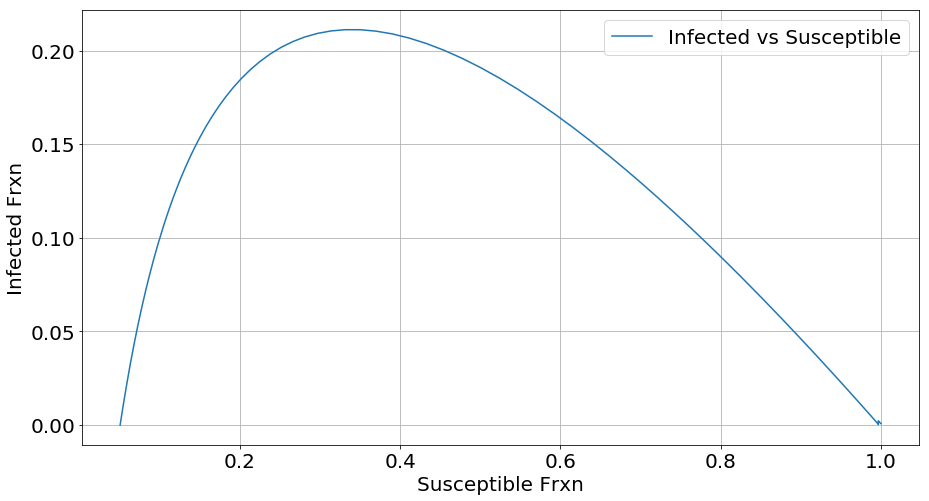

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(u[:, 0], u[:, 1], label="Infected vs Susceptible")

plt.xlabel('Susceptible Frxn', fontsize = 20)
plt.ylabel('Infected Frxn', fontsize = 20)

plt.legend(fontsize = 20)
plt.grid(True)
plt.show()

NameError: name 'tr_list' is not defined

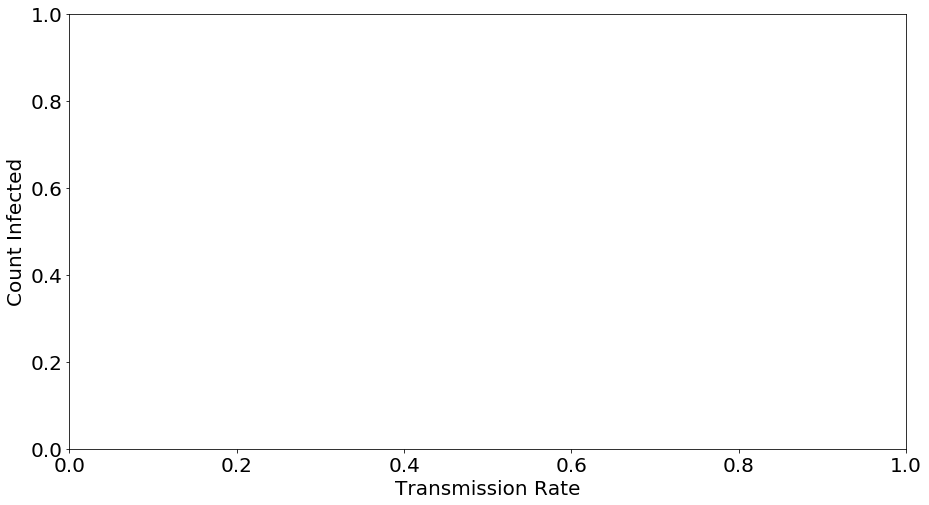

In [98]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8, forward=True)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Transmission Rate', fontsize = 20)
plt.ylabel('Count Infected', fontsize = 20)

plt.plot(tr_list, peak_list, label="Peak Count Infected")
plt.plot(tr_list, final_list, label="Final Count Infected")
plt.legend(fontsize = 20)
plt.show()
